## Foreign Holdings of Government Securities

In [232]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests

# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
import seaborn as sns

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [233]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "en",
    "categories": {
        "institutions": "all",
        "investments": [
            "ae2927afb16f2e2",
            "077bb741e0cac7a",
            "5648797b3f25966",
            "2dd81931fde75ee"
        ],
        "resident_type": "all"
    },
    "request": [
        {
            "table": "mex_banxico_ca138",
            "variables": [
                "3cf1aba6da15c63"
            ]
        }
    ],
    "from": "2012-01-26"
}

response = get_tukan_api_request(payload)

Success getting the data


In [234]:
data = response["data"]

In [235]:
data[["investments__ref", "investments"]].drop_duplicates()

,investments__ref,investments
0,077bb741e0cac7a,CETEs
7,2dd81931fde75ee,Udibonos
14,5648797b3f25966,MBONOS
21,ae2927afb16f2e2,Fixed income - government


## Daily outflows in government securities - foreign

In [281]:
#Filter foreign data
f_data = data[data["resident_type__ref"] == "9ee3531979d31bc"].copy()
f_data = f_data[f_data["investments__ref"] == "ae2927afb16f2e2"].copy()
f_data.loc[:,"daily_chg"] = f_data["3cf1aba6da15c63"] - f_data["3cf1aba6da15c63"].shift()

In [282]:
full_df_range = pd.DataFrame()
full_df_range["date"] = pd.date_range("2012-01-01", "2021-12-31")
f_data = pd.merge(full_df_range, f_data, how = "left", on = "date")
f_data

,date,investments__ref,investments,institutions__ref,institutions,resident_type__ref,resident_type,3cf1aba6da15c63,daily_chg
0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,9.657207e+11,NaN
2,2012-01-03,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,9.794968e+11,1.377618e+10
3,2012-01-04,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,9.834665e+11,3.969690e+09
4,2012-01-05,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,9.916221e+11,8.155520e+09
...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,1.638414e+12,-2.197790e+09
3649,2021-12-28,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,1.636984e+12,-1.429880e+09
3650,2021-12-29,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,1.636566e+12,-4.179500e+08
3651,2021-12-30,ae2927afb16f2e2,Fixed income - government,47f672ec4b5ab27,Private sector,9ee3531979d31bc,Foreign,1.638627e+12,2.060210e+09


In [12]:
f_data_2021 = f_data[f_data["date"].dt.year == 2021].reset_index(drop = True).copy()

In [27]:
f_data_2021.loc[:,"week_day"] = [x.weekday() for x in f_data_2021["date"]]
f_data_2021.loc[:,"month"] = [x.month for x in f_data_2021["date"]]

In [30]:
f_data_2021.set_index("date", inplace=True)

In [267]:
DAYS = ['Dom.','Lun.', 'Mar.', 'Mie.', 'Jue.', 'Vie.', 'Sab.']
MONTHS = ['Ene.', 'Feb.', 'Mar.', 'Abr.', 'Mayo', 'Jun.', 'Jul.', 'Ago.', 'Sept.', 'Oct.', 'Nov.', 'Dic.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None,**kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            elif date == start:
                ticks[0] = "Ene."
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    # current_cmap = mpl.cm.seismic_r
    # current_cmap.set_bad(color='black')
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

In [237]:
from highlight_text import HighlightText, ax_text, fig_text

ipykernel_launcher:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


<AxesSubplot:>

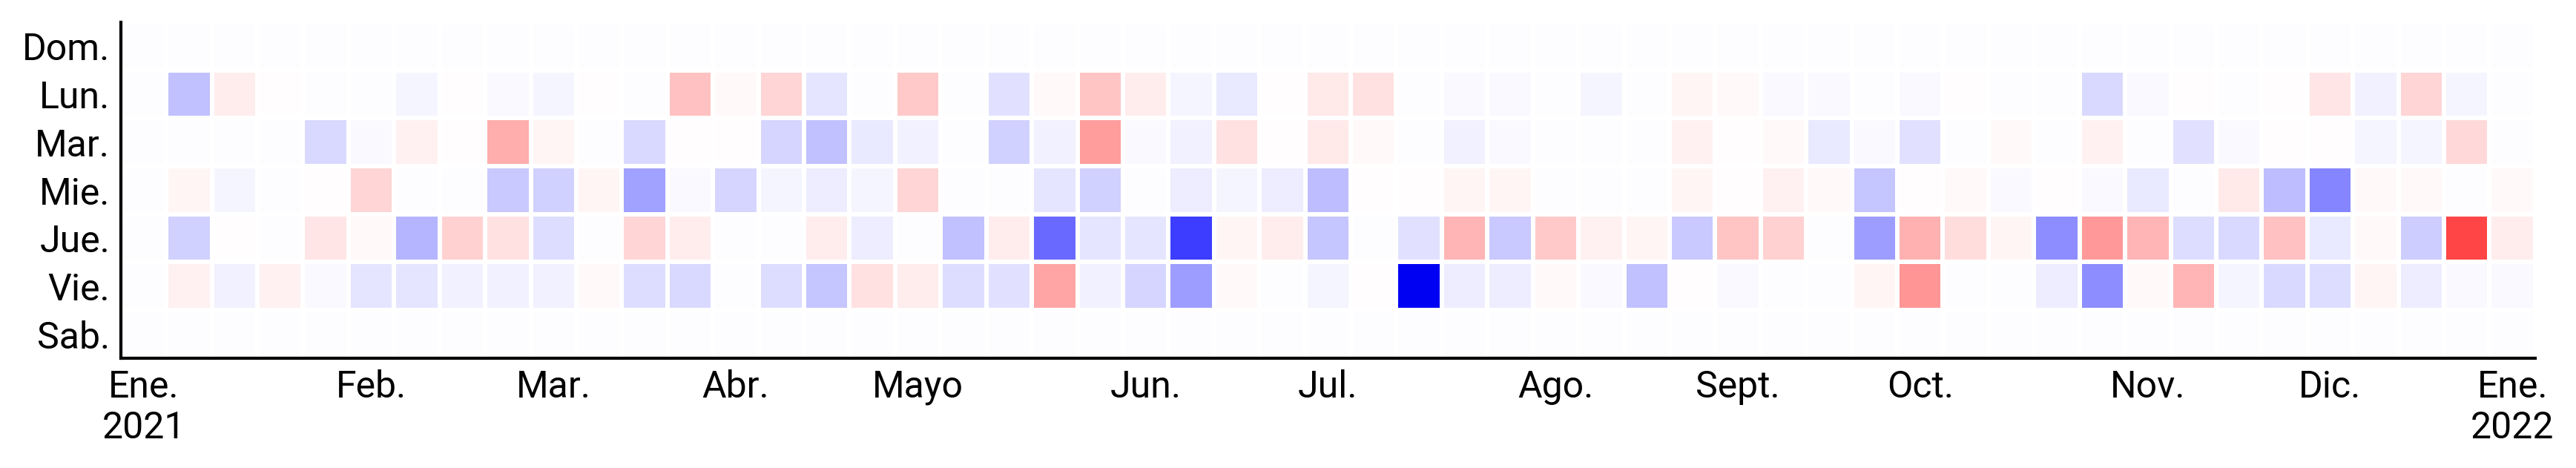

In [268]:
fig = plt.figure(figsize=(14,2), dpi = 300)

# ax_7 = plt.subplot(711)
ax_1 = plt.subplot(111)

f_data_aux = f_data[f_data["date"].dt.year == 2021].reset_index(drop = True).copy()
# f_data_aux = f_data_aux[f_data_aux["investments__ref"] == "077bb741e0cac7a"]
cum_flow = f_data_aux["daily_chg"].sum()/1000000
last_value = f_data_aux["3cf1aba6da15c63"].iloc[-1]/1000000
f_data_aux.set_index("date", inplace=True)

date_heatmap(f_data_aux["daily_chg"]/1000000, cmap = "seismic_r", ax = ax_1, norm=mpl.colors.TwoSlopeNorm(vmin=-f_data["daily_chg"].max()/1000000, vcenter=0., vmax=f_data["daily_chg"].max()/1000000), linewidths = 1, edgecolors = "white")


ipykernel_launcher:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
ipykernel_launcher:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


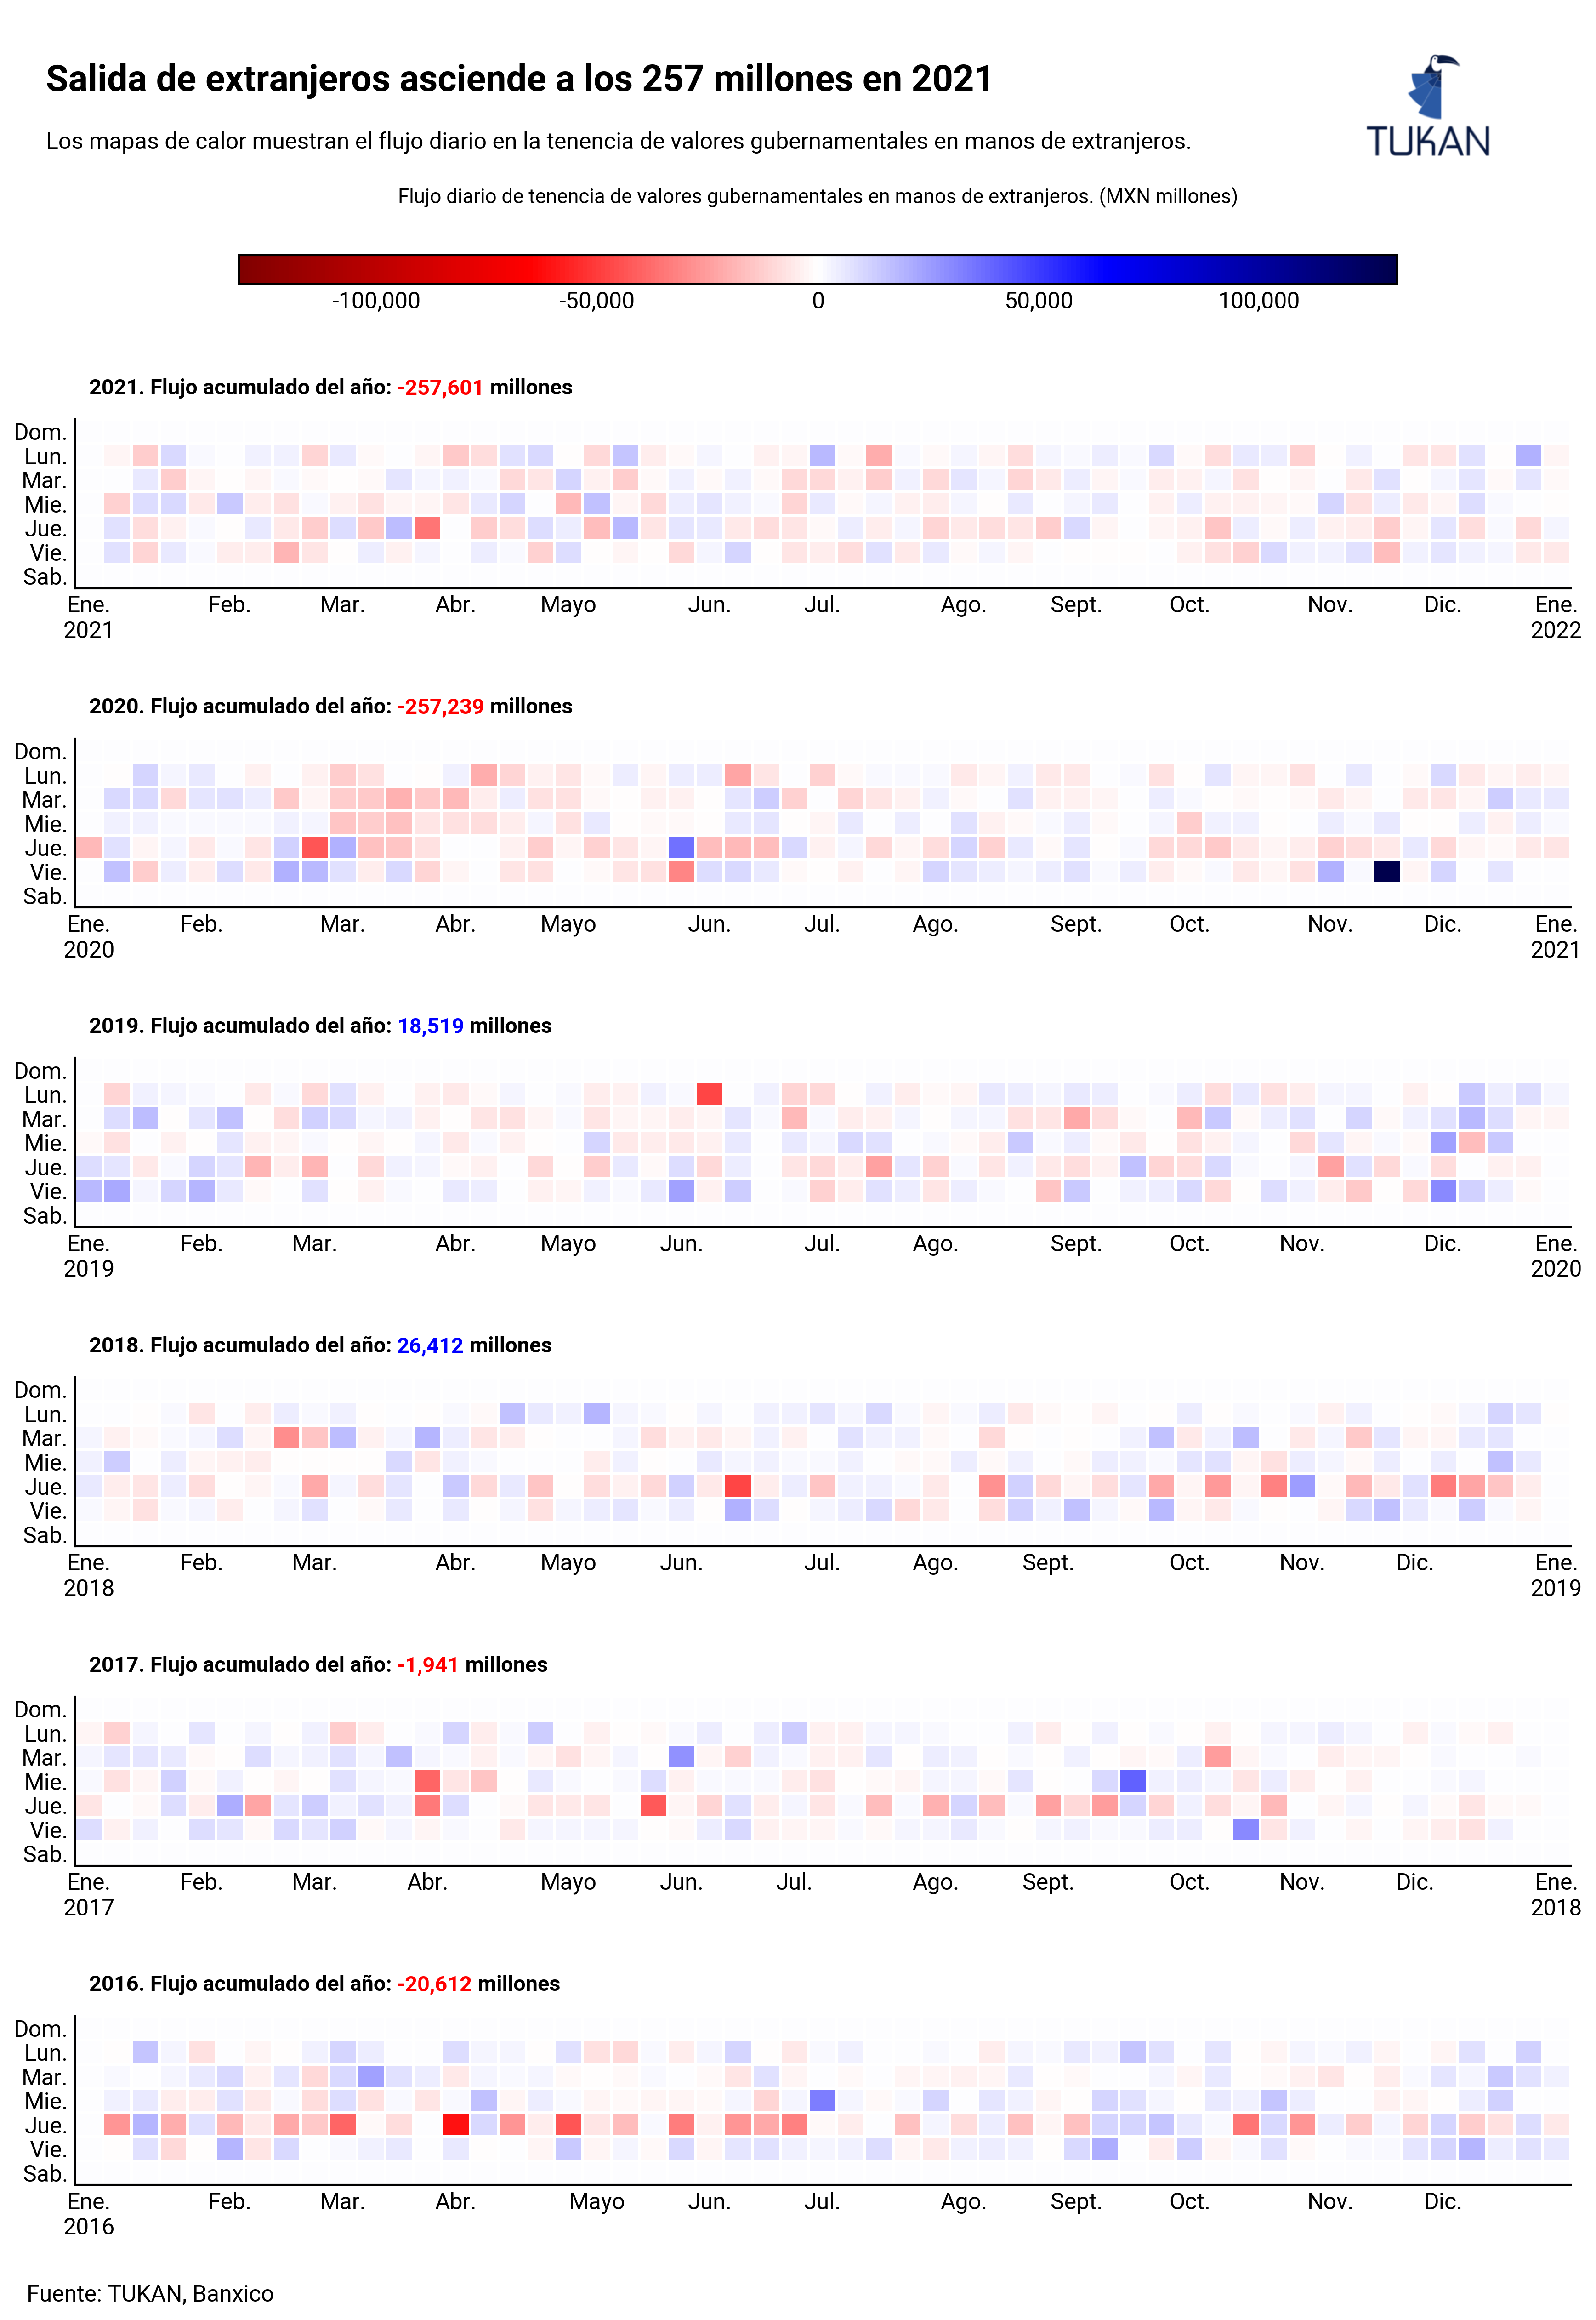

In [287]:
fig = plt.figure(figsize=(14,14), dpi = 300)

# ax_7 = plt.subplot(711)
ax_1 = plt.subplot(711)
ax_2 = plt.subplot(712)
ax_3 = plt.subplot(713)
ax_4 = plt.subplot(714)
ax_5 = plt.subplot(715)
ax_6 = plt.subplot(716)

# heatmap=ax_1.imshow([f_data.daily_chg/1000000], cmap = "seismic_r", norm=mpl.colors.TwoSlopeNorm(vmin=f_data["daily_chg"].min()/1000000, vcenter=0., vmax=f_data["daily_chg"].max()/1000000))
# heatmap.set_visible(False)
# ax_7.axes.set_axis_off()

axs = fig.axes
# ax_2 = plt.subplot(122)

for index, year in enumerate(reversed(range(2016, 2022))):
    f_data_aux = f_data[f_data["date"].dt.year == year].reset_index(drop = True).copy()
    # f_data_aux = f_data_aux[f_data_aux["investments__ref"] == "077bb741e0cac7a"]
    cum_flow = f_data_aux["daily_chg"].sum()/1000000
    last_value = f_data_aux["3cf1aba6da15c63"].iloc[-1]/1000000
    f_data_aux.set_index("date", inplace=True)
    date_heatmap(f_data_aux["daily_chg"]/1000000, cmap = "seismic_r", ax = axs[index], norm=mpl.colors.TwoSlopeNorm(vmin=-f_data["daily_chg"].max()/1000000, vcenter=0., vmax=f_data["daily_chg"].max()/1000000), linewidths = 1, edgecolors = "white")
    if cum_flow < 0:
        text_color = "red"
    else:
        text_color = "blue"
    ax_text(x = 0, y = -2.2,
    s = f"{round(year,1)}. Flujo acumulado del año: <{cum_flow:,.0f}> millones",
    highlight_textprops=[{"color": text_color}], ax = axs[index], size = 11.25, weight = "bold")
    # axs[index].annotate(
    # f"{round(year,1)}. Flujos acumulados {cum_flow:,.0f} millones",
    # xy=(0, 0),
    # xycoords="data",
    # xytext=(0, 30),
    # textcoords="offset points",
    # color="black",
    # size=11.5,
    # va="center",
    # ha="left",
    # weight = "bold"
    # )

plt.subplots_adjust(wspace=0.4, 
                    hspace=0.89,
                    bottom = -0.2)
# plt.colorbar(ax = ax_2)

# --- Dummy heatmap

cbar_ax = fig.add_axes([0.14, .95, 0.74, 0.1])
cbar_ax.axis("off")
plt.colorbar(format = ticker.StrMethodFormatter('{x:,.0f}'), ax = cbar_ax, orientation = "horizontal", aspect = 40)
cbar_ax.annotate(
    f"Flujo diario de tenencia de valores gubernamentales en manos de extranjeros. (MXN millones)",
    xy=(.5, 0),
    xycoords="data",
    xytext=(0, 15),
    textcoords="offset points",
    color="black",
    size=10.5,
    va="center",
    ha="center"
    )

fig.text(
    0.11,
    1.05,
    "Salida de extranjeros asciende a los 257 millones en 2021",
    size=19,
    weight = "bold"
)

fig.text(
    0.11,
    1.02,
    "Los mapas de calor muestran el flujo diario en la tenencia de valores gubernamentales en manos de extranjeros.",
    size=12
)
# Add footer
fig.text(0.1, -0.095, "Fuente: TUKAN, Banxico", fontsize=12)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .98, 0.095, 0.11], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "flux_values_gov.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)